In [35]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)


# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
train_df.columns

Index(['brand', 'material', 'size', 'compartments', 'laptop_compartment',
       'is_waterproof', 'style', 'color', 'weight_capacity', 'price'],
      dtype='object')

In [38]:
train_df['weight_capacity_int'] = train_df['weight_capacity'].astype(int)
cols_to_transform = [
    'brand', 'material', 'size', 'compartments', 'laptop_compartment',
    'is_waterproof', 'style', 'color', 'weight_capacity'
]
other_features = ['weight_capacity_int']
# other_features = ['brand']
# cols_to_transform = ['weight_capacity']

In [37]:
# df_stacked[current_features]

In [39]:
all_features = cols_to_transform + other_features

# XGB Model Parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "verbosity": 0,
}

def run_xgb_oof(
    df,
    features,
    target_col,
    n_splits=10,
    params={},
    num_boost_round=200,
    early_stopping_rounds=20
):
    """
    Trains an XGB model in a K-Fold manner and returns:
    - oof_preds: The out-of-fold predictions for each row in df.
    - performance: The RMSE computed on out-of-fold predictions.
    """

    # Prepare array for OOF predictions
    oof_preds = np.zeros(len(df))
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df), 1):
        train_fold = df.iloc[train_idx].copy()
        valid_fold = df.iloc[valid_idx].copy()
        
        # Fit on the train fold, transform both train and valid
        te = TargetEncoder()
        train_te = te.fit_transform(train_fold[cols_to_transform], train_fold[target_col])
        valid_te = te.transform(valid_fold[cols_to_transform])

        # Convert to DataFrames
        train_te = pd.DataFrame(train_te, columns=cols_to_transform, index=train_fold.index)
        valid_te = pd.DataFrame(valid_te, columns=cols_to_transform, index=valid_fold.index)
        
        # Rebuild the DataFrame with transformed features + numeric
        X_train = pd.concat([train_te, train_fold[other_features]], axis=1)
        y_train = train_fold[target_col].values
        
        X_valid = pd.concat([valid_te, valid_fold[other_features]], axis=1)
        y_valid = valid_fold[target_col].values

        # Convert to XGBoost DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        
        # Train XGB
        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        # Predict on validation fold
        preds_valid = bst.predict(dvalid)
        oof_preds[valid_idx] = preds_valid
        
        # Compute fold RMSE
        fold_rmse = root_mean_squared_error(y_valid, preds_valid)
        fold_metrics.append(fold_rmse)
    
    # Overall OOF RMSE
    overall_rmse = root_mean_squared_error(df[target_col], oof_preds)
    print(f"OOF RMSE: {overall_rmse:.4f}")
    
    return oof_preds, overall_rmse

# Sequentially Build N Models
N = 300  # Number of sequential models to build
best_score = float('inf')
accepted_oof_columns = []  # Which OOF columns we've kept so far

df_stacked = train_df.copy()  # Start from original training set
performance_list = []

for level in range(1, N+1):
    # print(f"\n=== Level {level} ===")
    
    # Decide which features to use. At each level, we include:
    #   - Original features
    #   - All previously-generated OOF prediction columns
    # current_features = all_features + [
    #     col for col in df_stacked.columns 
    #     if col.startswith("xgb_oof_lvl")
    # ]
    current_features = all_features + accepted_oof_columns
    new_oof_col = f"xgb_oof_lvl{level}"


    
    # Run cross-validation and get OOF predictions
    oof_preds, score = run_xgb_oof(
        df_stacked,
        features=current_features,
        target_col=target,
        n_splits=10,
        params=params,
        num_boost_round=200,
        early_stopping_rounds=20
    )
    
    # Append performance
    performance_list.append(score)
    
    # Add these OOF predictions as a new feature for the next level
    # df_stacked[f"xgb_oof_lvl{level}"] = oof_preds
    df_stacked[new_oof_col] = oof_preds
    
    # If performance improved, accept this new feature; otherwise prune
    if score < best_score:
        print(f"Level {level}: New best score achieved: {score:.4f} (previous best was {best_score:.4f})")
        best_score = score
        accepted_oof_columns.append(new_oof_col)
    else:
        print(f"Level {level}: No improvement; pruning column '{new_oof_col}'.")
        # Remove the column from df_stacked
        df_stacked.drop(columns=[new_oof_col], inplace=True)

# Print the performance of each level
for lvl, perf in enumerate(performance_list, 1):
    print(f"Level {lvl} OOF RMSE: {perf:.4f}")


OOF RMSE: 38.6982
Level 1: New best score achieved: 38.6982 (previous best was inf)
OOF RMSE: 38.7011
Level 2: No improvement; pruning column 'xgb_oof_lvl2'.
OOF RMSE: 38.7003
Level 3: No improvement; pruning column 'xgb_oof_lvl3'.
OOF RMSE: 38.7086
Level 4: No improvement; pruning column 'xgb_oof_lvl4'.
OOF RMSE: 38.7052
Level 5: No improvement; pruning column 'xgb_oof_lvl5'.
OOF RMSE: 38.6979
Level 6: New best score achieved: 38.6979 (previous best was 38.6982)
OOF RMSE: 38.6989
Level 7: No improvement; pruning column 'xgb_oof_lvl7'.
OOF RMSE: 38.7017
Level 8: No improvement; pruning column 'xgb_oof_lvl8'.
OOF RMSE: 38.7000
Level 9: No improvement; pruning column 'xgb_oof_lvl9'.
OOF RMSE: 38.6994
Level 10: No improvement; pruning column 'xgb_oof_lvl10'.
OOF RMSE: 38.6989
Level 11: No improvement; pruning column 'xgb_oof_lvl11'.
OOF RMSE: 38.6990
Level 12: No improvement; pruning column 'xgb_oof_lvl12'.
OOF RMSE: 38.6988
Level 13: No improvement; pruning column 'xgb_oof_lvl13'.
OOF RM

<Axes: >

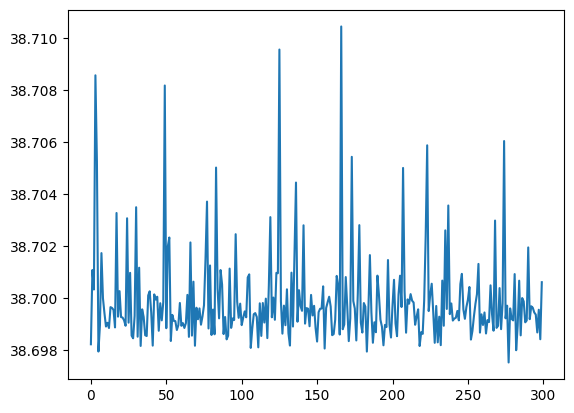

In [40]:
sns.lineplot(performance_list)

In [14]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
data_splits = []

for train_index, val_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    te = TargetEncoder(target_type="continuous", smooth=20)
    train_te = te.fit_transform(train_fold[cols_to_transform], train_fold[target])
    val_te = te.transform(val_fold[cols_to_transform])

    # Convert to DataFrames
    train_te = pd.DataFrame(train_te, columns=cols_to_transform, index=train_fold.index)
    val_te = pd.DataFrame(val_te, columns=cols_to_transform, index=val_fold.index)
    
    train_te[target] = train_fold[target]
    val_te[target] = val_fold[target]

    data_splits.append((train_te, val_te))

    # dtrain = xgb.DMatrix(train_te, label=train_fold[target], enable_categorical=True)
    # dvalid = xgb.DMatrix(val_te, label=val_fold[target], enable_categorical=True)

In [ ]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "verbosity": 0,
}


results = {name: [] for name in ['baseline', 'stacked']}

for i, (train_fold, valid_fold) in enumerate(data_splits, 1):
    dtrain = xgb.DMatrix(train_fold[cols_to_transform], label=train_fold[target], enable_categorical=True)
    dvalid = xgb.DMatrix(valid_fold[cols_to_transform], label=val_fold[target], enable_categorical=True)

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=[(dtrain, "train"), (dvalid, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,
    )
    
    y_pred = bst.predict(dvalid)
    rmse = root_mean_squared_error(dvalid.get_label(), y_pred)
    results['baseline'].append(rmse)



ValueError: All arrays must be of the same length

In [ ]:
pd.DataFrame(results)

In [16]:
train_fold[cols_to_transform]

,weight_capacity
0,78.891189
1,81.351436
2,81.458312
3,81.362671
4,81.458312
...,...
299994,83.379240
299996,81.450312
299997,76.974541
299998,81.385971
